In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import layers
import PIL
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
train, test = keras.utils.image_dataset_from_directory("/kaggle/input/sq-dog-chic-cat/Dataset", 
                                                      validation_split=0.1,
                                                      subset='both',
                                                      seed=42)

Found 11491 files belonging to 4 classes.
Using 10342 files for training.
Using 1149 files for validation.


In [4]:
print(train)
class_names = train.class_names

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


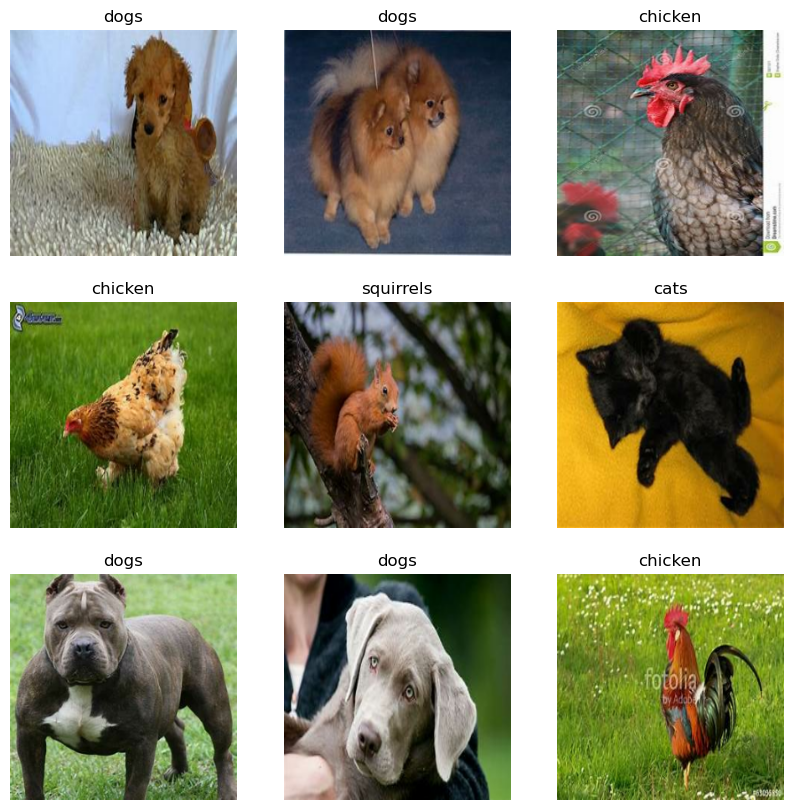

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    

## Configure the dataset for performance

In [7]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [8]:
'''AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)'''

'AUTOTUNE = tf.data.AUTOTUNE\n\ntrain = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)\ntest = test.cache().prefetch(buffer_size=AUTOTUNE)'

## Standardize the data

In [7]:
normalization_layer = layers.Rescaling(1./255)

normalize = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalize))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model Development

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [11]:
num_classes = len(class_names)
img_shape = (256,256,3)

In [97]:
base_model = tf.keras.applications.resnet.ResNet101(input_shape=img_shape,
                                                         include_top=False,
                                                        pooling='avg',
                                                         weights=None)
base_model.trainable = True
base_model.summary()

                                                                                                  
 conv4_block20_3_bn (BatchNorma  (None, 16, 16, 1024  4096       ['conv4_block20_3_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block20_add (Add)        (None, 16, 16, 1024  0           ['conv4_block19_out[0][0]',      
                                )                                 'conv4_block20_3_bn[0][0]']     
                                                                                                  
 conv4_block20_out (Activation)  (None, 16, 16, 1024  0          ['conv4_block20_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_blo

In [98]:
inputs = tf.keras.Input(shape=img_shape)
x = normalization_layer(inputs)
x = base_model(x, training=True)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 dense_92 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_93 (Dense)            (None, 256)               131328    
                                                                 
 dense_94 (Dense)            (None, 64)                164

In [99]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [101]:
epochs=10
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/10
324/324 [==============================] - 220s 679ms/step - loss: 0.6696 - accuracy: 0.7484 - val_loss: 0.7112 - val_accuracy: 0.7424
Epoch 2/10
324/324 [==============================] - 220s 679ms/step - loss: 0.6262 - accuracy: 0.7683 - val_loss: 0.6297 - val_accuracy: 0.7563
Epoch 3/10
324/324 [==============================] - 220s 677ms/step - loss: 0.6044 - accuracy: 0.7734 - val_loss: 0.6817 - val_accuracy: 0.7450
Epoch 4/10
324/324 [==============================] - 220s 678ms/step - loss: 0.5900 - accuracy: 0.7844 - val_loss: 0.6374 - val_accuracy: 0.7641
Epoch 5/10
324/324 [==============================] - 220s 679ms/step - loss: 0.5506 - accuracy: 0.8023 - val_loss: 0.6160 - val_accuracy: 0.7694
Epoch 6/10
324/324 [==============================] - 220s 677ms/step - loss: 0.5286 - accuracy: 0.8092 - val_loss: 0.5971 - val_accuracy: 0.7850
Epoch 7/10
324/324 [==============================] - 219s 676ms/step - loss: 0.4987 - accuracy: 0.8200 - val_loss: 0.6519 -

## Model Evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Assignment (3 layers)

In [6]:
y = np.concatenate([y for x, y in test], axis=0)


In [7]:
y

array([2, 3, 2, ..., 2, 0, 2], dtype=int32)

In [8]:
y.shape

(1149,)

In [9]:
x = np.concatenate([x for x, y in test], axis=0)


In [10]:
x = x.reshape(x.shape[0],-1)
x.shape

(1149, 196608)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca_x = pca.fit_transform(x)
pca_x.shape

(1149, 2)

In [12]:
inputs = tf.keras.layers.Input((2,))
c = layers.Dense(5, activation='relu')(inputs)
c = layers.Dense(6, activation='relu')(c)
c = layers.Dense(4, activation='relu')(c)
outputs = layers.Dense(4, activation='softmax')(c)
model_1 = tf.keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 6)                 36        
                                                                 
 dense_2 (Dense)             (None, 4)                 28        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
epochs=1
history = model_1.fit(
  pca_x,y,
  epochs=epochs
)

36/36 [==============================] - 6s 4ms/step - loss: 1609.1624 - accuracy: 0.2097


In [18]:
class ModelWrapper():
    def __init__(self, model):
        self.model = model
        
    def predict(self, X):
        pred = self.model.predict(X)
        labels = np.argmax(pred, axis=-1)
        
        return labels
    
model_2 = ModelWrapper(model_1)

9600/9600 [==============================] - 15s 2ms/step


/opt/conda/lib/python3.10/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: >

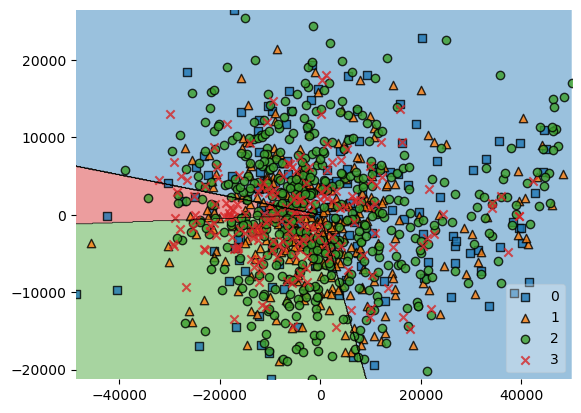

In [19]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(pca_x,y, clf=model_2, legend=4)